/home/ph290/miniconda2/envs/py38/lib/python3.8/site-packages/iris/coords.py:1803: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/home/ph290/miniconda2/envs/py38/lib/python3.8/site-packages/iris/coords.py:1803: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/home/ph290/miniconda2/envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:620: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


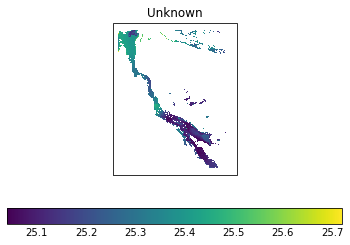

/home/ph290/miniconda2/envs/py38/lib/python3.8/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


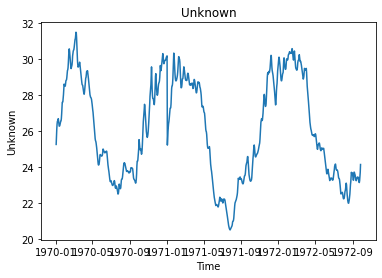

In [17]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
from iris import *
from iris.analysis import *
from iris.analysis.cartography import *
import numpy as np
import iris
import iris.coord_categorisation

from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import iris


my_cube = iris.load_cube('/data/local_ssd/cj362/S2P3Rv2.0/dhw/MIROC6_ssp245_1970_2100_surfacetemperature_all.nc')

#plot the 1st (0th) day of data as a map 
qplt.pcolormesh(my_cube[0])
plt.savefig('test.png')
plt.show()

#note, I've just sepected a subset of the time steps here (1st 1000 days) otherwise it takes for ever.
my_cube = my_cube[0:1000]

#averaging the data over an area, based on the example script on the wiki
my_cube.coord('latitude').guess_bounds()
my_cube.coord('longitude').guess_bounds()
grid_areas = area_weights(my_cube)
average_variable = my_cube[0:1000].collapsed(['latitude', 'longitude'],MEAN,weights=grid_areas)

#plot the timeseries:
qplt.plot(average_variable)
plt.savefig('test2.png')
plt.show()

## Plotting an area averaged annual timeseries

In [13]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import iris
import iris.coord_categorisation

def area_avg(cube):
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude', 'latitude'],iris.analysis.MEAN, weights=grid_areas)

cube = iris.load_cube('/data/local_ssd/cj362/S2P3Rv2.0/dhw/MIROC6_ssp585_1970_2100_surfacetemperature_all.nc')


iris.coord_categorisation.add_year(cube,'time', name='year')
annual_cube=cube.aggregated_by('year',iris.analysis.MEAN)

annual_cube_area_avg = area_avg(annual_cube)



/home/ph290/miniconda2/envs/py38/lib/python3.8/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


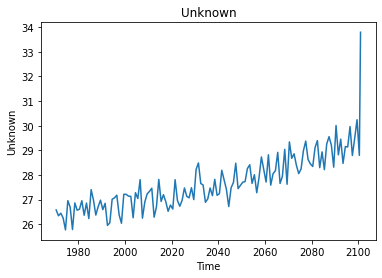

In [14]:
qplt.plot(annual_cube_area_avg)

There is some dodgy data around 2030 - likely just one field

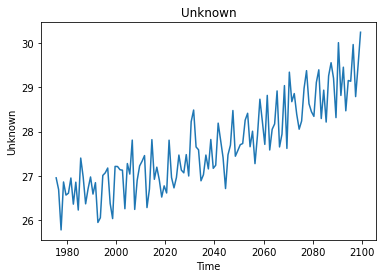

In [15]:
def extract_year_range_inclusive(cube,start_year,end_year):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    year_constraint = iris.Constraint(year=lambda tmp_yr: start_year <= tmp_yr <= end_year)
    return cube.extract(year_constraint)


start_year,end_year = 1975,2099
range_to_examine = extract_year_range_inclusive(annual_cube_area_avg,start_year,end_year)
qplt.plot(range_to_examine)

# Reading in DHW

initially looking at mean DHW timeseries

In [66]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import iris
import iris.coord_categorisation

def area_avg(cube):
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude', 'latitude'],iris.analysis.MEAN, weights=grid_areas)

cube = iris.load_cube('/data/local_ssd/cj362/S2P3Rv2.0/dhw/dhw_script_outputs/gfdl-cm4_ssp585_daily_dhw.nc')

#filtering out crazy values
cube_data = cube.data
cube_data[np.where(cube_data > 10000)] = cube_data.fill_value
cube_data.mask[np.where(cube_data > 10000)] = True



iris.coord_categorisation.add_year(cube,'time', name='year')
annual_cube=cube.aggregated_by('year',iris.analysis.MEAN)

annual_cube_area_avg = area_avg(annual_cube)



/home/ph290/miniconda2/envs/py38/lib/python3.8/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


### plotting up annual averages

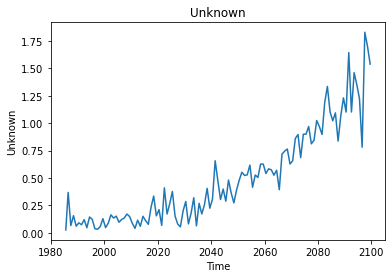

In [67]:
qplt.plot(annual_cube_area_avg)

In [135]:
try:
    iris.coord_categorisation.add_year(cube,'time', name='year')
except:
    pass
    
annual_cube_MAX=cube.aggregated_by('year',iris.analysis.MAX)

annual_cube_area_avg_max = area_avg(annual_cube_MAX)

/home/ph290/miniconda2/envs/py38/lib/python3.8/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


### Plotting up annual maximums to understad the shape of teh curve

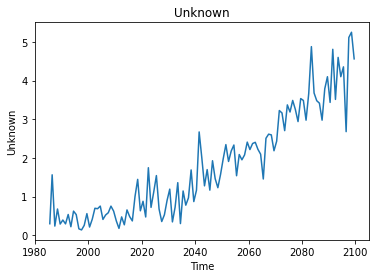

In [189]:
qplt.plot(annual_cube_area_avg_max)

## Now doing the detrending

In [167]:
def quadratic_function(x,a,b,c):    
    y = (a*(x**2.0)) + (b*x) + c
    return y

annual_cube_MAX_detrended = annual_cube_MAX.copy()
cube_data = annual_cube_MAX_detrended.data

shape = np.shape(cube_data)
output_cube_data = cube_data.copy()
output_cube_data[:] = np.nan

#Do the detrending
for i in range(shape[1]):
    for j in range(shape[2]):
        if cube_data.mask[0,i,j] == False:
            parameters, var = curve_fit(quadratic_function,np.arange(shape[0]),cube_data[:,i,j])
            y_values_anomaly_from_curve = quadratic_function(np.arange(shape[0]), *parameters)
            output_cube_data[:,i,j] = cube_data[:,i,j]-y_values_anomaly_from_curve

            

output_cube_data.data[np.where(np.isnan(output_cube_data))] = output_cube_data.fill_value
output_cube_data[np.where(output_cube_data == 0.0)] = output_cube_data.fill_value
output_cube_data.mask[np.where(np.isnan(output_cube_data))] = True
output_cube_data.mask[np.where(output_cube_data == output_cube_data.fill_value)] = True
annual_cube_MAX_detrended.data = output_cube_data

#Put the detrended data back in to the original cube
annual_cube_MAX_detrended.data = output_cube_data

### map of the detrended data for year 0

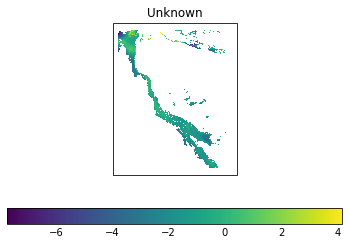

In [171]:
qplt.pcolormesh(annual_cube_MAX_detrended[0])

### Spatial mean of teh detrended data

/home/ph290/miniconda2/envs/py38/lib/python3.8/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


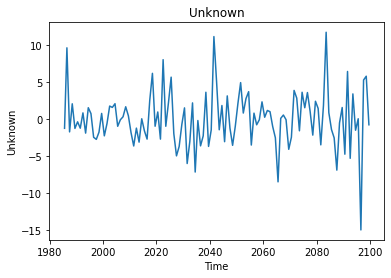

In [172]:
annual_cube_MAX_detrended_area_avg = area_avg(annual_cube_MAX_detrended)
qplt.plot(annual_cube_MAX_detrended_area_avg)

## Composite data, i.e. averging across a subset of years

In [183]:
def extract_year_range_inclusive(cube,start_year,end_year):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    year_constraint = iris.Constraint(year=lambda tmp_yr: start_year <= tmp_yr <= end_year)
    return cube.extract(year_constraint)


start_year,end_year = 2080,2085
annual_cube_MAX_detrended_range_of_years_to_examine_late_part_of_centry = extract_year_range_inclusive(annual_cube_MAX_detrended,start_year,end_year)


start_year,end_year = 2020,2025
annual_cube_MAX_detrended_range_of_years_to_examine_early_part_of_centry = extract_year_range_inclusive(annual_cube_MAX_detrended,start_year,end_year)


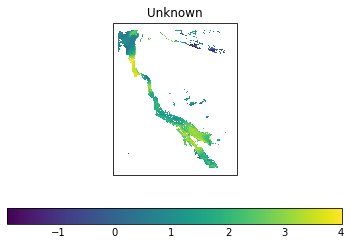

In [184]:
annual_cube_MAX_detrended_range_of_years_to_examine_late_part_of_centry_time_averaged = annual_cube_MAX_detrended_range_of_years_to_examine_late_part_of_centry.collapsed('time',iris.analysis.MEAN)
annual_cube_MAX_detrended_range_of_years_to_examine_early_part_of_centry_time_averaged = annual_cube_MAX_detrended_range_of_years_to_examine_early_part_of_centry.collapsed('time',iris.analysis.MEAN)



qplt.pcolormesh(annual_cube_MAX_detrended_range_of_years_to_examine_late_part_of_centry_time_averaged)

## diffrence between early and late hypothetical el nino periods (as an example)

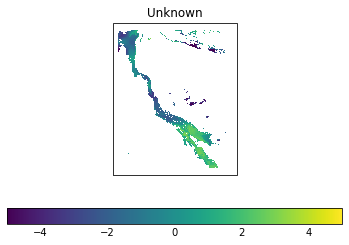

In [188]:
qplt.pcolormesh(annual_cube_MAX_detrended_range_of_years_to_examine_late_part_of_centry_time_averaged - annual_cube_MAX_detrended_range_of_years_to_examine_early_part_of_centry_time_averaged,vmin=-5,vmax=5)

### bringing together as a single time mean the a acrverage across (for example) different la nina periods

In [201]:
def extract_list_of_years(cube,year_list):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    tmp_year_list = cube.coord('year').points
    indexes_to_use = np.nonzero(np.in1d(tmp_year_list, year_list))[0]
    return cube[indexes_to_use]



year_list = [2000,2001,2010,2011]


## the below uses the list of years above and pulls just those years from our cube 'annual_cube_MAX_detrended'
annual_cube_MAX_detrended_selected_year = extract_list_of_years(annual_cube_MAX_detrended,year_list)


In [199]:
annual_cube_MAX_detrended_selected_year

<iris 'Cube' of unknown / (1) (time: 4; latitude: 161; longitude: 131)>